In [1]:
%pylab inline

Populating the interactive namespace from numpy and matplotlib


In [11]:
import matplotlib.pyplot as plt
import h5py
import rotation as rot
import barstrength as strng
import kapparot as krot
import time_conversion as tiempo

h=0.732
G = 4.299e-6
a0=1
H0 = h*100
omega_lambda=0.716
omega_matter=0.1277/(h**2.)
omega0 = omega_lambda + omega_matter

vector = ('00','01','03')

aa = np.loadtxt('/home/ornela/python/ornella/redshift_outputs.txt')
aexp = aa[:,2]


snapshot=range(255,60,-1)
for isnap in snapshot:
    snap = h5py.File('/home/ornela/python/ornella/outputs_1/snap_'+str('%03d'%isnap)+'.h5py', 'r')

    cm   = snap['subhalo_000/Center'].value
    r200 = snap['subhalo_000/R200'].value
    #aexp = snap['subhalo_0'+ str('%s' %vector[i])+ '/Time'].value

    pstr = snap['subhalo_000/Str/Coordinates'].value
    masa_str = snap['subhalo_000/Str/Masses'].value
    vel  = snap['subhalo_000/Str/Velocities'].value

    fo =open('/home/ornela/python/barra/barpos_05.dat','a')
    
    z = a0/aexp[isnap] - 1.
    Ht = H0*np.sqrt(omega_lambda+(1-omega0)*(1+z)**2+omega_matter*(1+z)**3)
    t = tiempo.conv(z, h, omega_lambda, omega_matter)

#---aca paso las coordenadas respecto al centro de la galaxia------
    xstr = (pstr[:,0]-cm[0])*aexp[isnap]/h
    ystr = (pstr[:,1]-cm[1])*aexp[isnap]/h
    zstr = (pstr[:,2]-cm[2])*aexp[isnap]/h
    r = np.sqrt(xstr**2+ystr**2+zstr**2)

    v_x = vel[:,0] *np.sqrt(aexp[isnap]) + Ht *xstr/1000.
    v_y = vel[:,1] *np.sqrt(aexp[isnap]) + Ht *ystr/1000.
    v_z = vel[:,2] *np.sqrt(aexp[isnap]) + Ht *zstr/1000.

    #print aexp[isnap]

#----------------------masas----------------------------
    masa_str = masa_str/h

    r200 = r200*aexp[isnap]/h

    rgal=0.15*r200

    limit = np.where(r<rgal)
    r_sort = np.sort(r[limit])
    r_indice = np.argsort(r[limit])

    Mc_str = cumsum((masa_str[limit])[r_indice])
    M_gal = Mc_str[-1]

#------------------ calculamos M90------------------------------------------
    razon = Mc_str/M_gal
    noventa, = np.where(razon < 0.9)
    cincuenta, = np.where(razon < 0.5)

    r90 = r_sort[noventa]
    r50 = r_sort[cincuenta]
    M90 = Mc_str[noventa]                

#-------------------------------------------------------------------            
    corte1,=np.where(r<r90[-1])
    
    veloc,=np.where(r<r50[-1])

#----------componentes de la velocidad del centro de masa------------
    vxcm = sum(masa_str[veloc]*v_x[veloc])/sum(masa_str[veloc])
    vycm = sum(masa_str[veloc]*v_y[veloc])/sum(masa_str[veloc])
    vzcm = sum(masa_str[veloc]*v_z[veloc])/sum(masa_str[veloc])

#----- velocidades de las estrellas respecto del centro de masa de la galaxia---------
    vx = vel[:,0] - vxcm
    vy = vel[:,1] - vycm
    vz = vel[:,2] - vzcm

    e1x,e2x,e3x,e1y,e2y,e3y,e1z,e2z,e3z = rot.rot1(masa_str,xstr,ystr,zstr,vx,vy,vz,0.5)

    xn = e1x*xstr + e1y*ystr + e1z*zstr
    yn = e2x*xstr + e2y*ystr + e2z*zstr
    zn = e3x*xstr + e3y*ystr + e3z*zstr
    vxn = e1x*vx + e1y*vy + e1z*vz
    vyn = e2x*vx + e2y*vy + e2z*vz
    vzn = e3x*vx + e3y*vy + e3z*vz

    rr = np.sqrt(xn**2+yn**2+zn**2)
    corte2,=np.where(rr<0.5)
    
    A2max, rmax, phi = strng.a2max(masa_str[corte2], xn[corte2], yn[corte2], 20)

    phi = phi*180./pi

    if phi < 0:
        phi2= phi+360
    else: 
        phi2= phi
    phi2 = phi2/2.

    #print phi2

    fo.write(str('%03d'%isnap) +'\t'+
             str('%.6f'% t) +'\t'+
             str('%12.6f'% A2max) +'\t'+
             str('%12.6f'% rmax) +'\t'+
             str('%12.6f'% phi2) +'\n')
    fo.close()


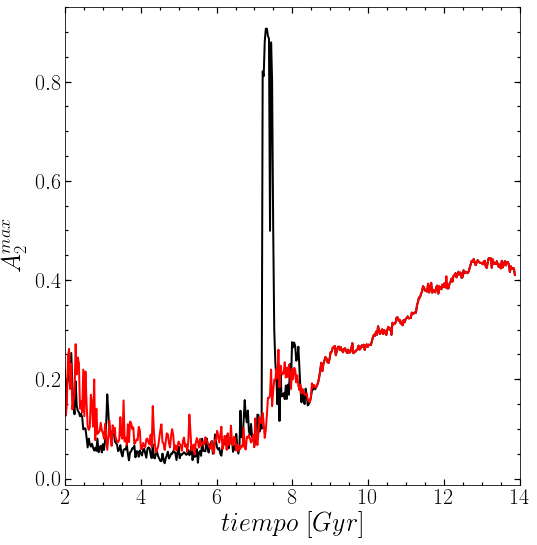

In [50]:
import matplotlib.pyplot as plt
from __future__ import unicode_literals

matplotlib.rcParams['text.usetex'] = True
matplotlib.rcParams['text.latex.unicode'] = True

cm1=np.loadtxt('/home/ornela/python/barra/barpos_time2.dat')

t1 =cm1[:,1]
A2max1 =cm1[:,2]

cm2=np.loadtxt('/home/ornela/python/barra/barpos_time3.dat')

t2 =cm2[:,1]
A2max2 =cm2[:,2]

# time =[]
# A2=[]
# aux=range(0,len(t),1)
# for j in aux:
#     time.append(t[j])
#     A2.append(A2max[j])

fig=plt.figure(1, figsize=(8,8))
fig.subplots_adjust(bottom=0.12, left =0.16, right = 0.95, top = 0.95)
ax3=fig.add_subplot(111)
ax3.plot(t1,A2max1,'-', lw=2, color='k')
ax3.plot(t2,A2max2,'-', lw=2, color='r')
ax3.set_xlim(2,14)
#ax3.set_ylim(0.04,0.45)
ax3.minorticks_on()
ax3.tick_params( labelsize=22)
ax3.tick_params('both', length=3, width=1.2,which='minor', direction='in', right='on',top='on')
ax3.tick_params('both', length=6, width=1.2,which='major', direction='in', right='on',top='on')  
plt.xlabel(r'$tiempo$ $[Gyr]$', fontsize=26)
plt.ylabel(r'$A_{2}^{max}$',fontsize=26)

plt.show()

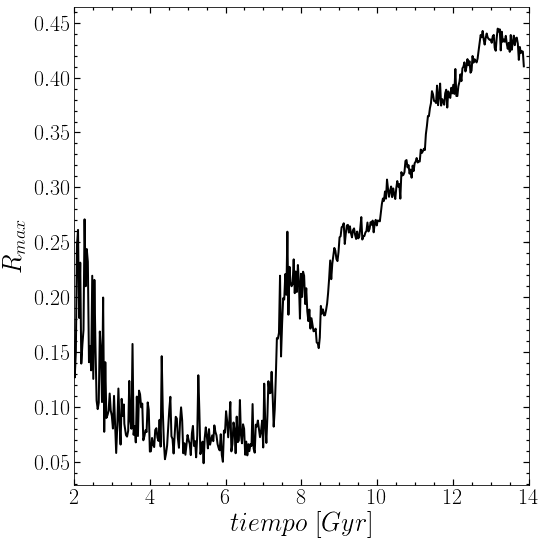

In [5]:
import matplotlib.pyplot as plt
from __future__ import unicode_literals

matplotlib.rcParams['text.usetex'] = True
matplotlib.rcParams['text.latex.unicode'] = True

cm2=np.loadtxt('/home/ornela/python/barra/barpos_time3.dat')

t =cm2[:,1]
rmax =cm2[:,2]

# time =[]
# A2=[]
# aux=range(0,len(t),1)
# for j in aux:
#     time.append(t[j])
#     A2.append(A2max[j])

fig=plt.figure(1, figsize=(8,8))
fig.subplots_adjust(bottom=0.12, left =0.16, right = 0.95, top = 0.95)
ax3=fig.add_subplot(111)
ax3.plot(t,rmax,'-', lw=2, color='k')
#ax3.plot(t2,A2max2,'-', lw=2, color='r')
ax3.set_xlim(2,14)
#ax3.set_ylim(0.04,0.45)
ax3.minorticks_on()
ax3.tick_params( labelsize=22)
ax3.tick_params('both', length=3, width=1.2,which='minor', direction='in', right='on',top='on')
ax3.tick_params('both', length=6, width=1.2,which='major', direction='in', right='on',top='on')  
plt.xlabel(r'$tiempo$ $[Gyr]$', fontsize=26)
plt.ylabel(r'$R_{max}$',fontsize=26)

plt.show()

[ -122.75811688  6101.55586493]


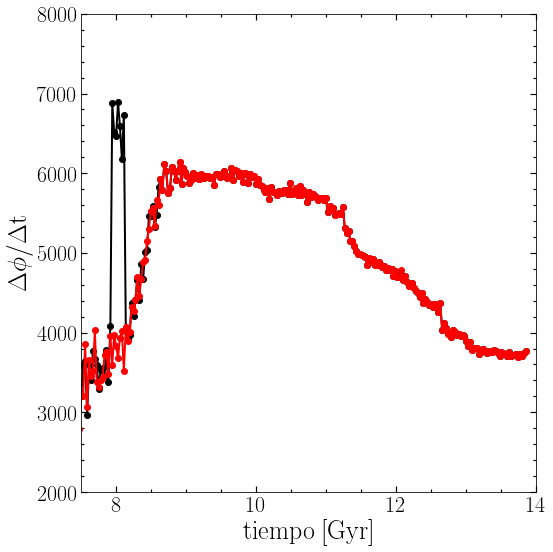

In [55]:
import matplotlib.pyplot as plt
from scipy.interpolate import *
import time_conversion as tiempo
from __future__ import unicode_literals

matplotlib.rcParams['text.usetex'] = True
matplotlib.rcParams['text.latex.unicode'] = True



h=0.732
G = 4.299e-6
a0=1
H0 = h*100
omega_lambda=0.716
omega_matter=0.1277/(h**2.)
omega0 = omega_lambda + omega_matter

# atime = np.loadtxt('/home/ornela/python/ornella/redshift_outputs.txt')
# aexp = atime[:,2]

#cm=np.loadtxt('/home/ornela/python/barra/barra_pos.dat')
cm=np.loadtxt('/home/ornela/python/barra/barpos_time3.dat')
phi =cm[:,4]
time =cm[:,1]

cm1=np.loadtxt('/home/ornela/python/barra/barpos_time2.dat')
phi1 =cm1[0:240,4]
time1 =cm1[0:240,1]


# mask, = np.where(time>5)

# phi=phi[mask]
# time=time[mask]

# phi1=phi1[mask]
# time1=time1[mask]

# #phi = phi[1:]
# #phi = phi[1:194]
# aexp = aexp[::-1]
# aexp = aexp[0:len(phi)]
# z = a0/aexp - 1.
# time = tiempo.conv(z, h, omega_lambda, omega_matter)
# #print time

aa = len(phi)-1
k = 1
phi2 = np.zeros(len(phi))
phi2[-1] = phi[-1]

delta_phi = np.zeros(len(phi))
delta_t = np.zeros(len(phi))
tt = np.zeros(len(phi))

for i in range(aa,0,-1):
    aux = phi[i]-phi[i-1]
    if aux > 0:
        phi2[i-1] = phi[i-1]+360*k
        k += 1
    else:
        phi2[i-1] = phi[i-1]+360*(k-1)
    
    delta_t [i] = time[i-1]-time[i]
    delta_phi[i] = phi2[i-1]-phi2[i]
    tt[i] = (time[i-1]+time[i])/2.

delta_t = delta_t[1:]
delta_phi = delta_phi[1:]
tt = tt[1:]

veloc = delta_phi/delta_t
#-------------------------------------------
aa = len(phi1)-1
k = 1
phi21 = np.zeros(len(phi1))
phi21[-1] = phi1[-1]

delta_phi1 = np.zeros(len(phi1))
delta_t1 = np.zeros(len(phi1))
tt1 = np.zeros(len(phi1))

for i in range(aa,0,-1):
    aux = phi1[i]-phi1[i-1]
    if aux > 0:
        phi21[i-1] = phi1[i-1]+360*k
        k += 1
    else:
        phi21[i-1] = phi1[i-1]+360*(k-1)
    
    delta_t1 [i] = time1[i-1]-time1[i]
    delta_phi1[i] = phi21[i-1]-phi21[i]
    tt1[i] = (time1[i-1]+time1[i])/2.

delta_t1 = delta_t1[1:]
delta_phi1 = delta_phi1[1:]
tt1 = tt1[1:]

veloc1 = delta_phi1/delta_t1


#mask, = np.where(time>7.71)

p2 = polyfit(tt,veloc,1)
print p2

fig=plt.figure(1, figsize=(8,8))
fig.subplots_adjust(bottom=0.12, left =0.16, right = 0.95, top = 0.95)
ax3=fig.add_subplot(111)
ax3.plot(tt1,veloc1,'ko-', lw=2)
ax3.plot(tt,veloc,'ro-', lw=2)

#ax3.plot(tt,polyval(p2,tt), 'r-', lw=2)
ax3.set_xlim(7.5,14)
ax3.set_ylim(2000,8000)
#plt.grid(True)
#ax3.set_ylim(90,115)
ax3.minorticks_on()
ax3.tick_params( labelsize=22)
ax3.tick_params('both', length=3, width=1.2,which='minor', direction='in', right='on',top='on')
ax3.tick_params('both', length=6, width=1.2,which='major', direction='in', right='on',top='on')

plt.xlabel(r'$\mathrm{tiempo\:[Gyr]}$', fontsize=26)
plt.ylabel(r'$\mathrm{\Delta \phi/\Delta t}$',fontsize=26)
#ax3.twinx() #me hace un eje del otro lado
#ax3.axis('square') #hace el plot cuadrado
#ax3.set_axisbelow(True)


plt.show()


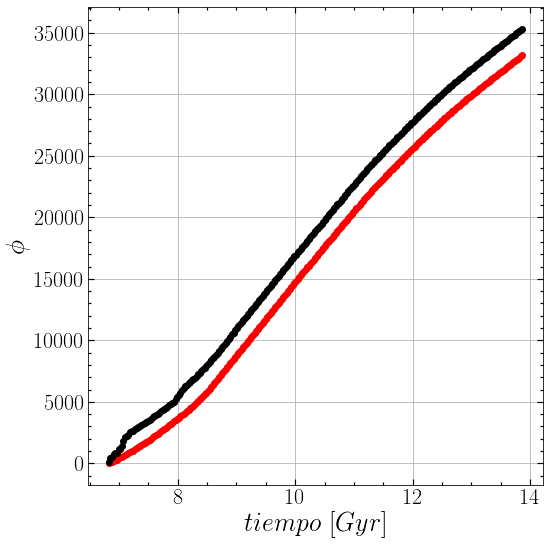

In [46]:
import matplotlib.pyplot as plt
from scipy.interpolate import *
import time_conversion as tiempo
from __future__ import unicode_literals

matplotlib.rcParams['text.usetex'] = True
matplotlib.rcParams['text.latex.unicode'] = True

h=0.732
G = 4.299e-6
a0=1
H0 = h*100
omega_lambda=0.716
omega_matter=0.1277/(h**2.)
omega0 = omega_lambda + omega_matter

#atime = np.loadtxt('/home/ornela/python/ornella/redshift_outputs.txt')
#aexp = atime[:,2]

#cm=np.loadtxt('/home/ornela/python/barra/barra_pos.dat')
cm=np.loadtxt('/home/ornela/python/barra/barpos_time3.dat')
phi =cm[:,4]
time = cm[:,1]

cm1=np.loadtxt('/home/ornela/python/barra/barpos_time2.dat')
phi1 =cm1[:,4]
time1 = cm1[:,1]

# aexp = aexp[::-1]
# aexp = aexp[0:len(phi)]
# z = a0/aexp - 1.
# time = tiempo.conv(z, h, omega_lambda, omega_matter)

mask, = np.where(time>6.8)
mask1,= np.where(time1>6.8)

phi=phi[mask]
time=time[mask]

phi1=phi1[mask1]
time1=time1[mask1]

aa = len(phi)-1
k = 1
phi2 = np.zeros(len(phi))
phi2[-1] = phi[-1]
for i in range(aa,0,-1):
    aux = phi[i]-phi[i-1]
    if aux > 0:
        phi2[i-1] = phi[i-1]+360*k
        k += 1
    else:
        phi2[i-1] = phi[i-1]+360*(k-1)
        
aa = len(phi1)-1
k = 1
phi21 = np.zeros(len(phi1))
phi21[-1] = phi1[-1]
for i in range(aa,0,-1):
    aux = phi1[i]-phi1[i-1]
    if aux > 0:
        phi21[i-1] = phi1[i-1]+360*k
        k += 1
    else:
        phi21[i-1] = phi1[i-1]+360*(k-1)
        
# for i in range(aa,-1,-1):
# aux = phi[i+1]-phi[i]
# print aux

# p1 = polyfit(time,phi21,2)
# print p1
 
fig=plt.figure(1, figsize=(8,8))
fig.subplots_adjust(bottom=0.12, left =0.16, right = 0.95, top = 0.95)
ax3=fig.add_subplot(111)
ax3.plot(time,phi2,'ro', lw=2)
ax3.plot(time1,phi21,'ko', lw=2)
#ax3.plot(time[mask],polyval(p1,time[mask]), 'g-', lw=2)
#ax3.set_xlim(7.7,7.9)
#ax3.set_ylim(3500,5500)
plt.grid(True)
#ax3.set_ylim(90,115)
ax3.minorticks_on()
ax3.tick_params( labelsize=22)
ax3.tick_params('both', length=3, width=1.2,which='minor', direction='in', right='on',top='on')
ax3.tick_params('both', length=6, width=1.2,which='major', direction='in', right='on',top='on')  
plt.xlabel(r'$tiempo$ $[Gyr]$', fontsize=26)
plt.ylabel(r'$\phi$',fontsize=26)


plt.show()


In [86]:
import h5py
import rotation as rot
import time_conversion as tiempo
import barstrength as strng
from numpy import matrix
from __future__ import unicode_literals

matplotlib.rcParams['text.usetex'] = True
matplotlib.rcParams['text.latex.unicode'] = True

h=0.732
G = 4.299e-6
a0=1
H0 = h*100
omega_lambda=0.716
omega_matter=0.1277/(h**2.)
omega0 = omega_lambda + omega_matter

aa = np.loadtxt('/home/ornela/python/ornella/redshift_outputs.txt')
aexp = aa[:,2]

qq = np.loadtxt('/home/ornela/python/barra/barpos_time3.dat')
phi =qq[:,4]
time =qq[:,1]
Rmax = qq[:,3]

phi = phi*pi/180.

vector = ('00','01','03')

i=0
snapshot=range(496,250,-1)
for isnap in snapshot:
    snap = h5py.File('/home/ornela/python/ornella/outputs_1/snap_'+str('%03d'%isnap)+'.h5py', 'r')

    fo =open('/home/ornela/python/barra/momento_ang_fin2.dat','a')
    #print isnap
    cm   = snap['subhalo_000/Center'].value
    r200 = snap['subhalo_000/R200'].value
    #aexp = snap['subhalo_000/Time'].value

    pstr = snap['subhalo_000/Str/Coordinates'].value
    #IDs = snap['subhalo_000/Str/Ids'].value
    masa_str = snap['subhalo_000/Str/Masses'].value
    vel  = snap['subhalo_000/Str/Velocities'].value
    
    z = a0/aexp[isnap] - 1.
    Ht = H0*np.sqrt(omega_lambda+(1-omega0)*(1+z)**2+omega_matter*(1+z)**3)

    #---aca paso las coordenadas respecto al centro de la galaxia------
    xstr = (pstr[:,0]-cm[0])*aexp[isnap]/h
    ystr = (pstr[:,1]-cm[1])*aexp[isnap]/h
    zstr = (pstr[:,2]-cm[2])*aexp[isnap]/h
    r = np.sqrt(xstr**2+ystr**2+zstr**2)

    v_x = vel[:,0] *np.sqrt(aexp[isnap]) + Ht *xstr/1000.
    v_y = vel[:,1] *np.sqrt(aexp[isnap]) + Ht *ystr/1000.
    v_z = vel[:,2] *np.sqrt(aexp[isnap]) + Ht *zstr/1000.

    #----------------------masas----------------------------
    masa_str = masa_str/h

    r200 = r200*aexp[isnap]/h
    rgal=0.15*r200

    limit = np.where(r<rgal)
    r_sort = np.sort(r[limit])
    r_indice = np.argsort(r[limit])

    Mc_str = cumsum((masa_str[limit])[r_indice])
    M_gal = Mc_str[-1]

    #------------------ calculamos M90------------------------------------------
    razon = Mc_str/M_gal
    noventa, = np.where(razon < 0.9)
    cincuenta, = np.where(razon < 0.5)

    r90 = r_sort[noventa]
    r50 = r_sort[cincuenta]
    M90 = Mc_str[noventa]                

    #------------------masa total en r200 (Mvir)--------------------------         
    #corte1,=np.where(r<r90[-1])
    veloc,=np.where(r<r50[-1])

    #----------componentes de la velocidad del centro de masa------------
    vxcm = sum(masa_str[veloc]*v_x[veloc])/sum(masa_str[veloc])
    vycm = sum(masa_str[veloc]*v_y[veloc])/sum(masa_str[veloc])
    vzcm = sum(masa_str[veloc]*v_z[veloc])/sum(masa_str[veloc])

    #----- velocidades de las estrellas respecto del centro de masa de la galaxia---------
    vx = vel[:,0] - vxcm
    vy = vel[:,1] - vycm
    vz = vel[:,2] - vzcm
    
    dd = range(496,300,-1)
    dd.remove(428)
    if isnap in dd:
        raux = 2*r50[-1]
        #print 'primero', isnap
    elif (isnap == 428) or ((isnap < 301) & (isnap > 283)):
        #print 'segundo', isnap
        raux = r50[-1]
    elif (isnap > 271) & (isnap < 284):
        raux = 0.75
        #print 'tercero', isnap
    elif isnap < 272:
        raux = 0.5
        #print 'cuarto', isnap
    

    e1x,e2x,e3x,e1y,e2y,e3y,e1z,e2z,e3z = rot.rot1(masa_str,xstr,ystr,zstr,vx,vy,vz,raux)

    ##posiciones de partículas que se quiere graficar
    ##como lo de arriba me da los versores hago las posiciones con esto 

    xn = e1x*xstr + e1y*ystr + e1z*zstr
    yn = e2x*xstr + e2y*ystr + e2z*zstr
    zn = e3x*xstr + e3y*ystr + e3z*zstr
    vxn = e1x*vx + e1y*vy + e1z*vz
    vyn = e2x*vx + e2y*vy + e2z*vz
    vzn = e3x*vx + e3y*vy + e3z*vz
        
    aa=2*Rmax[i]
    bb=1.2*Rmax[i]
    cc=Rmax[i]
    
    xx = xn*cos(phi[i])+yn*sin(phi[i])
    yy = xn*sin(phi[i])-yn*cos(phi[i])
    zz = zn
    RR = np.sqrt((xx/aa)**2+(yy/bb)**2+(zz/cc)**2)
    mask, = np.where(RR<1)
    
    xn1 = xn[mask]
    yn1 = yn[mask]
    zn1 = zn[mask]
    vxn1 = vxn[mask]
    vyn1 = vyn[mask]
    vzn1 = vzn[mask]
    mstr = masa_str[mask]
    
    rcil = np.sqrt(xn1**2+yn1**2)
    
    mask2, = np.where((rcil>0.9*aa) & (rcil<aa))
    
    #print len(xn[mask])
    
    Lx = sum((yn1[mask2]*vzn1[mask2] - zn1[mask2]*vyn1[mask2])*mstr[mask2])
    Ly = sum((zn1[mask2]*vxn1[mask2] - xn1[mask2]*vzn1[mask2])*mstr[mask2])
    Lz = sum((xn1[mask2]*vyn1[mask2] - yn1[mask2]*vxn1[mask2])*mstr[mask2])
    
    #print Lx, Ly, Lz
    
    Ixx = sum(mstr[mask2]*(yn1[mask2]**2+zn[mask2]**2))
    Ixy = sum(mstr[mask2]*xn1[mask2]*yn1[mask2])
    Ixz = sum(mstr[mask2]*xn1[mask2]*zn1[mask2])
    Iyy = sum(mstr[mask2]*(xn1[mask2]**2+zn1[mask2]**2))
    Iyz = sum(mstr[mask2]*yn1[mask2]*zn1[mask2])
    Izz = sum(mstr[mask2]*(xn1[mask2]**2+yn1[mask2]**2))
    
    II = matrix([[Ixx,Ixy,Ixz],[Ixy, Iyy, Iyz], [Ixz, Iyz, Izz]])
    
    Iinv = II.I
    

#     print II
#     print II.I
    #print Ixx, Ixy, Ixz
    #print Iyy, Iyz, Izz
    
#     detI = Ixx*Iyy*Izz + 2*Ixy*Iyz*Ixz - Iyy*Ixz**2 - Ixx*Iyz**2 - Izz*Ixy**2
#     print detI
    
#     a13 = (Ixy*Iyz-Ixz*Iyy)/detI
#     a23 = (Ixz*Ixy-Iyz*Ixx)/detI
#     a33 = (Ixx*Iyy-Ixy**2)/detI
#     print a33
    
    omega = Iinv[2,0]*Lx +Iinv[2,1]*Ly + Iinv[2,2]*Lz
    #omegaz = median(Lz/Izz)
#     print omegaZ
    
#     omega2 = (xn[mask]*vyn[mask] - yn[mask]*vxn[mask])/rcil[mask]**2
#     omega3 = median(omega2)
    
#     VT =(xn[mask]*vyn[mask] - yn[mask]*vxn[mask])/rcil[mask]
    
#     fig=plt.figure(1,figsize=(8,8))
#     fig.subplots_adjust(bottom=0.12, left =0.18, right = 0.95, top = 0.95)
#     ax=fig.add_subplot(111)
#     plt.hist(VT,20)


    
    #plot(rcil[mask], omega2,'.')
    
    fo.write(str('%03d'%isnap) +'\t'+
             str('%.6f'% time[i]) +'\t'+
             str('%12.6f'% omega) +'\n')
    fo.close()
    
    i += 1

In [34]:
?mean


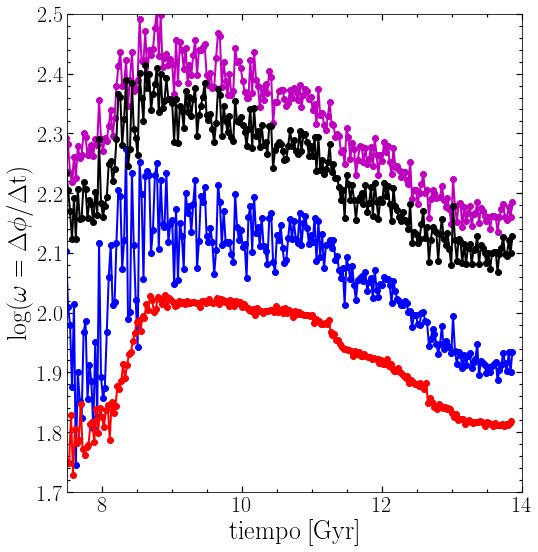

In [89]:
import matplotlib.pyplot as plt
from scipy.interpolate import *
import time_conversion as tiempo
from __future__ import unicode_literals

matplotlib.rcParams['text.usetex'] = True
matplotlib.rcParams['text.latex.unicode'] = True


#cm=np.loadtxt('/home/ornela/python/barra/barra_pos.dat')
cm=np.loadtxt('/home/ornela/python/barra/barpos_time3.dat')
phi =cm[:,4]
time =cm[:,1]

cmZ=np.loadtxt('/home/ornela/python/barra/momento_angZ.dat')
tZ =cmZ[:,1]
omegaZ =cmZ[:,2]

cm11=np.loadtxt('/home/ornela/python/barra/momento_ang_fin.dat')
t11 =cm11[:,1]
omega11 =cm11[:,2]

cm10=np.loadtxt('/home/ornela/python/barra/momento_ang_fin2.dat')
t10 =cm10[:,1]
omega10 =cm10[:,2]

cm13=np.loadtxt('/home/ornela/python/barra/momento_ang13.dat')
t13 =cm13[:,1]
omega13 =cm13[:,3]

cmZZ=np.loadtxt('/home/ornela/python/barra/momento_angZZZ.dat')
tZZ =cmZZ[:,1]
omegaZZ =cmZZ[:,2]
omega_median= cmZZ[:,3]


cm12=np.loadtxt('/home/ornela/python/barra/momento_ang12.dat')
t12 =cm12[:,1]
omega12 =cm12[:,2]

aa = len(phi)-1
k = 1
phi2 = np.zeros(len(phi))
phi2[-1] = phi[-1]

delta_phi = np.zeros(len(phi))
delta_t = np.zeros(len(phi))
tt = np.zeros(len(phi))

for i in range(aa,0,-1):
    aux = phi[i]-phi[i-1]
    if aux > 0:
        phi2[i-1] = phi[i-1]+360*k
        k += 1
    else:
        phi2[i-1] = phi[i-1]+360*(k-1)
    
    delta_t [i] = time[i-1]-time[i]
    delta_phi[i] = phi2[i-1]-phi2[i]
    tt[i] = (time[i-1]+time[i])/2.

delta_t = delta_t[1:]
delta_phi = delta_phi[1:]
tt = tt[1:]

veloc = delta_phi/delta_t


fig=plt.figure(1, figsize=(8,8))
fig.subplots_adjust(bottom=0.12, left =0.16, right = 0.95, top = 0.95)
ax3=fig.add_subplot(111)
ax3.plot(tZZ,log10(omegaZZ/1.022712086),'mo-', lw=2)
ax3.plot(t11,log10(omega11/1.022712086),'bo-', lw=2)
#ax3.plot(t12,log10(omega12/1.022712086),'go-', lw=2)
ax3.plot(tZ,log10(omegaZ/1.022712086),'ko-', lw=2)
#ax3.plot(t10,log10(omega10/1.022712086),'yo-', lw=2)
#ax3.plot(tZZ,log10(omega_median/1.022712086),'yo-', lw=2)
#ax3.plot(tZZ,log10(omega_mean/1.022712086),'o-', lw=2, color='purple')
ax3.plot(tt,log10(veloc*pi/180.),'ro-', lw=2)
#ax3.plot(tt,polyval(p2,tt), 'r-', lw=2)
ax3.set_xlim(7.5,14)
ax3.set_ylim(1.7,2.5)
#plt.grid(True)
#ax3.set_ylim(90,115)
ax3.minorticks_on()
ax3.tick_params( labelsize=22)
ax3.tick_params('both', length=3, width=1.2,which='minor', direction='in', right='on',top='on')
ax3.tick_params('both', length=6, width=1.2,which='major', direction='in', right='on',top='on')

plt.xlabel(r'$\mathrm{tiempo\:[Gyr]}$', fontsize=26)
plt.ylabel(r'$\mathrm{log(\omega = \Delta \phi/\Delta t)}$',fontsize=26)
#ax3.twinx() #me hace un eje del otro lado
#ax3.axis('square') #hace el plot cuadrado
#ax3.set_axisbelow(True)


plt.show()


In [21]:
dd =range(496,300,-1)
dd.remove(428)
print dd

[496, 495, 494, 493, 492, 491, 490, 489, 488, 487, 486, 485, 484, 483, 482, 481, 480, 479, 478, 477, 476, 475, 474, 473, 472, 471, 470, 469, 468, 467, 466, 465, 464, 463, 462, 461, 460, 459, 458, 457, 456, 455, 454, 453, 452, 451, 450, 449, 448, 447, 446, 445, 444, 443, 442, 441, 440, 439, 438, 437, 436, 435, 434, 433, 432, 431, 430, 429, 427, 426, 425, 424, 423, 422, 421, 420, 419, 418, 417, 416, 415, 414, 413, 412, 411, 410, 409, 408, 407, 406, 405, 404, 403, 402, 401, 400, 399, 398, 397, 396, 395, 394, 393, 392, 391, 390, 389, 388, 387, 386, 385, 384, 383, 382, 381, 380, 379, 378, 377, 376, 375, 374, 373, 372, 371, 370, 369, 368, 367, 366, 365, 364, 363, 362, 361, 360, 359, 358, 357, 356, 355, 354, 353, 352, 351, 350, 349, 348, 347, 346, 345, 344, 343, 342, 341, 340, 339, 338, 337, 336, 335, 334, 333, 332, 331, 330, 329, 328, 327, 326, 325, 324, 323, 322, 321, 320, 319, 318, 317, 316, 315, 314, 313, 312, 311, 310, 309, 308, 307, 306, 305, 304, 303, 302, 301]


In [17]:
?concatenate

In [27]:
snapshot=range(496,250,-1)
for isnap in snapshot:
    dd = range(496,300,-1)
    dd.remove(428)
    if isnap in dd:
        #raux = 2*r50[-1]
        print 'primero', isnap
    elif (isnap == 428) or ((isnap < 301) & (isnap > 283)):
        print 'segundo', isnap
        #raux = r50[-1]
    elif (isnap > 271) & (isnap < 284):
        raux = 0.75
        print 'tercero', isnap
    elif isnap < 272:
        raux = 0.5
        print 'cuarto', isnap

primero 496
primero 495
primero 494
primero 493
primero 492
primero 491
primero 490
primero 489
primero 488
primero 487
primero 486
primero 485
primero 484
primero 483
primero 482
primero 481
primero 480
primero 479
primero 478
primero 477
primero 476
primero 475
primero 474
primero 473
primero 472
primero 471
primero 470
primero 469
primero 468
primero 467
primero 466
primero 465
primero 464
primero 463
primero 462
primero 461
primero 460
primero 459
primero 458
primero 457
primero 456
primero 455
primero 454
primero 453
primero 452
primero 451
primero 450
primero 449
primero 448
primero 447
primero 446
primero 445
primero 444
primero 443
primero 442
primero 441
primero 440
primero 439
primero 438
primero 437
primero 436
primero 435
primero 434
primero 433
primero 432
primero 431
primero 430
primero 429
segundo 428
primero 427
primero 426
primero 425
primero 424
primero 423
primero 422
primero 421
primero 420
primero 419
primero 418
primero 417
primero 416
primero 415
primero 414
prim

In [15]:
import h5py
import rotation as rot
import time_conversion as tiempo
import barstrength as strng
from __future__ import unicode_literals

matplotlib.rcParams['text.usetex'] = True
matplotlib.rcParams['text.latex.unicode'] = True

h=0.732
G = 4.299e-6
a0=1
H0 = h*100
omega_lambda=0.716
omega_matter=0.1277/(h**2.)
omega0 = omega_lambda + omega_matter

aa = np.loadtxt('/home/ornela/python/ornella/redshift_outputs.txt')
aexp = aa[:,2]

qq = np.loadtxt('/home/ornela/python/barra/barpos_time3.dat')
phi =qq[:,4]
time =qq[:,1]
Rmax = qq[:,3]

phi = phi*pi/180.

vector = ('00','01','03')

i=0
snapshot=range(496,495,-1)
for isnap in snapshot:
    snap = h5py.File('/home/ornela/python/ornella/outputs_1/snap_'+str('%03d'%isnap)+'.h5py', 'r')
    print isnap
    #fo =open('/home/ornela/python/barra/momento_ang.dat','a')
    #print isnap
    cm   = snap['subhalo_000/Center'].value
    r200 = snap['subhalo_000/R200'].value
    #aexp = snap['subhalo_000/Time'].value

    pstr = snap['subhalo_000/Str/Coordinates'].value
    #IDs = snap['subhalo_000/Str/Ids'].value
    masa_str = snap['subhalo_000/Str/Masses'].value
    vel  = snap['subhalo_000/Str/Velocities'].value
    
    z = a0/aexp[isnap] - 1.
    Ht = H0*np.sqrt(omega_lambda+(1-omega0)*(1+z)**2+omega_matter*(1+z)**3)

    #---aca paso las coordenadas respecto al centro de la galaxia------
    xstr = (pstr[:,0]-cm[0])*aexp[isnap]/h
    ystr = (pstr[:,1]-cm[1])*aexp[isnap]/h
    zstr = (pstr[:,2]-cm[2])*aexp[isnap]/h
    r = np.sqrt(xstr**2+ystr**2+zstr**2)

    v_x = vel[:,0] *np.sqrt(aexp[isnap]) + Ht *xstr/1000.
    v_y = vel[:,1] *np.sqrt(aexp[isnap]) + Ht *ystr/1000.
    v_z = vel[:,2] *np.sqrt(aexp[isnap]) + Ht *zstr/1000.

    #----------------------masas----------------------------
    masa_str = masa_str/h

    r200 = r200*aexp[isnap]/h
    rgal=0.15*r200

    limit = np.where(r<rgal)
    r_sort = np.sort(r[limit])
    r_indice = np.argsort(r[limit])

    Mc_str = cumsum((masa_str[limit])[r_indice])
    M_gal = Mc_str[-1]

    #------------------ calculamos M90------------------------------------------
    razon = Mc_str/M_gal
    noventa, = np.where(razon < 0.9)
    cincuenta, = np.where(razon < 0.5)

    r90 = r_sort[noventa]
    r50 = r_sort[cincuenta]
    M90 = Mc_str[noventa]
    
    #print r90[-1]

    #------------------masa total en r200 (Mvir)--------------------------         
    #corte1,=np.where(r<r90[-1])
    veloc,=np.where(r<r50[-1])

    #----------componentes de la velocidad del centro de masa------------
    vxcm = sum(masa_str[veloc]*v_x[veloc])/sum(masa_str[veloc])
    vycm = sum(masa_str[veloc]*v_y[veloc])/sum(masa_str[veloc])
    vzcm = sum(masa_str[veloc]*v_z[veloc])/sum(masa_str[veloc])

    #----- velocidades de las estrellas respecto del centro de masa de la galaxia---------
    vx = vel[:,0] - vxcm
    vy = vel[:,1] - vycm
    vz = vel[:,2] - vzcm
    
    dd = range(496,300,-1)
    dd.remove(428)
    if isnap in dd:
        raux = 2*r50[-1]
        #print 'primero', isnap
    elif (isnap == 428) or ((isnap < 301) & (isnap > 283)):
        #print 'segundo', isnap
        raux = r50[-1]
    elif (isnap > 271) & (isnap < 284):
        raux = 0.75
        #print 'tercero', isnap
    elif isnap < 272:
        raux = 0.5
        #print 'cuarto', isnap
    

    e1x,e2x,e3x,e1y,e2y,e3y,e1z,e2z,e3z = rot.rot1(masa_str,xstr,ystr,zstr,vx,vy,vz,r90[-1])

    ##posiciones de partículas que se quiere graficar
    ##como lo de arriba me da los versores hago las posiciones con esto 

    xn = e1x*xstr + e1y*ystr + e1z*zstr
    yn = e2x*xstr + e2y*ystr + e2z*zstr
    zn = e3x*xstr + e3y*ystr + e3z*zstr
    vxn = e1x*vx + e1y*vy + e1z*vz
    vyn = e2x*vx + e2y*vy + e2z*vz
    vzn = e3x*vx + e3y*vy + e3z*vz
        
    aa=2*Rmax[i]
    bb=1.2*Rmax[i]
    cc=Rmax[i]
    
    #print Rmax[i]
    
    print aa, bb, cc
    
    xx = xn*cos(phi[0])+yn*sin(phi[0])
    yy = xn*sin(phi[0])-yn*cos(phi[0])
    zz = zn
    RR = np.sqrt((xx/aa)**2+(yy/bb)**2+(zz/cc)**2)
    mask, = np.where(RR <= 1.)
    
    Rcirc = np.sqrt(xn**2+yn**2)
    VT = (vyn*xn - vxn*yn)/Rcirc
    
#     fig=plt.figure(1, figsize=(16,16))
#     fig.subplots_adjust(bottom=0.12, left =0.16, right = 0.95, top = 0.95)
#     ax3=fig.add_subplot(221)
#     #ax3.plot(xn[mask],yn[mask],'r.', markersize=0.1)
#     ax3.plot(xn,yn,'k.', markersize=0.05)
    
#     #ax3.plot(tt,log10(veloc),'ro-', lw=2)
#     #ax3.plot(tt,polyval(p2,tt), 'r-', lw=2)
#     ax3.set_xlim(-5,5)
#     ax3.set_ylim(-5,5)
#     #plt.grid(True)
#     #ax3.set_ylim(90,115)
#     ax3.minorticks_on()
#     ax3.tick_params( labelsize=22)
#     ax3.tick_params('both', length=3, width=1.2,which='minor', direction='in', right='on',top='on')
#     ax3.tick_params('both', length=6, width=1.2,which='major', direction='in', right='on',top='on')
#     plt.xlabel(r'$\mathrm{x\:[kpc]}$', fontsize=26)
#     plt.ylabel(r'$\mathrm{y\:[kpc]}$',fontsize=26)
#     #ax3.twinx() #me hace un eje del otro lado
#     #ax3.axis('square') #hace el plot cuadrado
#     #ax3.set_axisbelow(True)
#     #plt.show()
    
#     #fig=plt.figure(2, figsize=(8,8))
#     #fig.subplots_adjust(bottom=0.12, left =0.16, right = 0.95, top = 0.95)
#     ax=fig.add_subplot(222)
#     #ax.plot(xn[mask],zn[mask],'r.', markersize=0.1)
#     ax.plot(xn,zn,'k.', markersize=0.05)
   
#     #ax.plot(tt,log10(veloc),'ro-', lw=2)
#     #ax.plot(tt,polyval(p2,tt), 'r-', lw=2)
#     ax.set_xlim(-5,5)
#     ax.set_ylim(-5,5)
#     #plt.grid(True)
#     #ax3.set_ylim(90,115)
#     ax.minorticks_on()
#     ax.tick_params( labelsize=22)
#     ax.tick_params('both', length=3, width=1.2,which='minor', direction='in', right='on',top='on')
#     ax.tick_params('both', length=6, width=1.2,which='major', direction='in', right='on',top='on')
#     plt.xlabel(r'$\mathrm{x\:[kpc]}$', fontsize=26)
#     plt.ylabel(r'$\mathrm{z\:[kpc]}$',fontsize=26)
#     #ax.twinx() #me hace un eje del otro lado
#     #ax.axis('square') #hace el plot cuadrado
#     #ax.set_axisbelow(True)
#     #plt.show()
    
#     #fig=plt.figure(3, figsize=(8,8))
#     #fig.subplots_adjust(bottom=0.12, left =0.16, right = 0.95, top = 0.95)
#     ax1=fig.add_subplot(223)
#     #ax1.plot(yn[mask],zn[mask],'r.', markersize=0.1)
#     ax1.plot(yn,zn,'k.', markersize=0.05)
#     #ax.plot(tt,log10(veloc),'ro-', lw=2)
#     #ax.plot(tt,polyval(p2,tt), 'r-', lw=2)
#     ax1.set_xlim(-5,5)
#     ax1.set_ylim(-5,5)
#     #plt.grid(True)
#     #ax3.set_ylim(90,115)
#     ax1.minorticks_on()
#     ax1.tick_params( labelsize=22)
#     ax1.tick_params('both', length=3, width=1.2,which='minor', direction='in', right='on',top='on')
#     ax1.tick_params('both', length=6, width=1.2,which='major', direction='in', right='on',top='on')
#     plt.xlabel(r'$\mathrm{y\:[kpc]}$', fontsize=26)
#     plt.ylabel(r'$\mathrm{z\:[kpc]}$',fontsize=26)
#     #ax.twinx() #me hace un eje del otro lado
#     #ax.axis('square') #hace el plot cuadrado
#     #ax.set_axisbelow(True)
#     plt.show()

    
    #print len(xn[mask])
    
#     Lz = (xn[mask]*vyn[mask] - yn[mask]*vxn[mask])*masa_str[mask]
#     Izz = masa_str[mask]*zn[mask]**2
#     omega = sum(Lz)/sum(Izz)
    #omega = sum(Omega[mask])
    
#     fo.write(str('%03d'%isnap) +'\t'+
#              str('%.6f'% time[i]) +'\t'+
#              str('%12.6f'% omega) +'\n')
#     fo.close()
    #print phi[0]
    i += 1

496
1.048518 0.6291108 0.524259


In [81]:
mask2, = np.where((RR >0.8) & (RR<1))
print median(VT[mask2])


76.2285


152936
62.0642817911


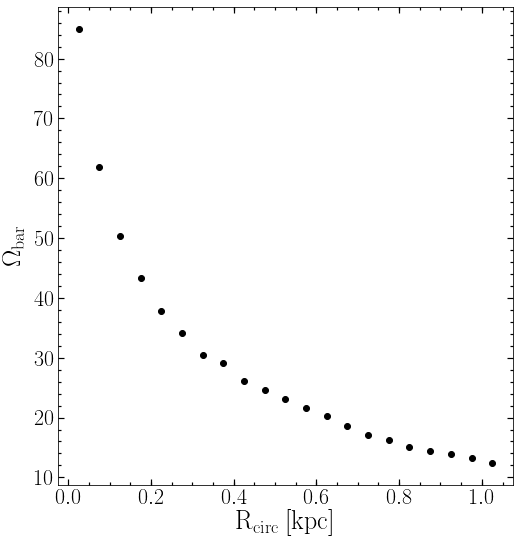

In [16]:
step = 0.05
ww = frange(0,aa,step)
ww1 = frange(step/2.,aa,step)


VT = VT[mask]
Rcirc = Rcirc[mask]

print len(VT)
print sum(VT)/len(VT)

fig=plt.figure(1, figsize=(8,8))
fig.subplots_adjust(bottom=0.12, left =0.16, right = 0.95, top = 0.95)
ax3=fig.add_subplot(111)

for i in range(0,len(ww)-1):
    mask3, = np.where((Rcirc>ww[i]) & (Rcirc<ww[i+1]))
    veel = mean(VT[mask3]/(ww1[i]*2*pi))
    #veel2 =median(VT[mask3]/ww1[i])

    ax3.plot(ww1[i],veel,'ko', lw=2)
    #ax3.plot(ww1[i],veel2,'ro', lw=2)
    #print veel2, ww1[i]
#ax3.set_xlim(0,.1)
#ax3.set_ylim(2.8,3.9)
#plt.grid(True)
#ax3.set_ylim(90,115)
ax3.minorticks_on()
ax3.tick_params( labelsize=22)
ax3.tick_params('both', length=3, width=1.2,which='minor', direction='in', right='on',top='on')
ax3.tick_params('both', length=6, width=1.2,which='major', direction='in', right='on',top='on')

plt.xlabel(r'$\mathrm{R_{circ}\:[kpc]}$', fontsize=26)
plt.ylabel(r'$\mathrm{\Omega_{bar}}$',fontsize=26)
#ax3.twinx() #me hace un eje del otro lado
#ax3.axis('square') #hace el plot cuadrado
#ax3.set_axisbelow(True)


plt.show()


In [69]:
print ww1

[ 0.025  0.075  0.125  0.175  0.225  0.275  0.325  0.375  0.425  0.475
  0.525  0.575  0.625  0.675  0.725  0.775  0.825  0.875  0.925  0.975
  1.025]


In [81]:


rr = np.array([1,2,3,4,5,6,7,8,9,10,11,12])

m1, = np.where(rr > 4)
m2, = np.where(ss > 10)

print rr[m1]
ss = rr[m1]
print ss
print ss[m2]

[ 5  6  7  8  9 10 11 12]
[ 5  6  7  8  9 10 11 12]
[11 12]
